# Warming Stripes with Hadoop Map-Reduce

The famous warming stripes are a very simple yet effective to visualize global or local temperature trends and to rise awareness of the global warming problem and climate crisis. 
They were introduced by British climatologist Ed Hawkins [ShowYourStripes.info](https://showyourstripes.info/s/globe)   
   
## Assignment Goals and Data Sets   
   
The goal of this assignment is to visualize temperature trends in germany based on data offered to everybody free of charge by the German Meteorological Service (DWD)
The dataset used in this assignement can be accessed under: [Weather Data](https://opendata.dwd.de/climate_environment/CDC/regional_averages_DE/monthly/air_temperature_mean/)
 
Please note the corresponding copyright information provided by the DWD: [Copyright](https://www.dwd.de/EN/service/copyright/copyright_node.html)   
   
This excercise is meant as a proof-of-concept and uses rather few data points. But the underlying algorithm and structure is applicable to much larger datasets. When working with weather data, we can imagine that large datasets can easily be accumulated by using temperature data from tiny IoT weather stations from all over the world, that log the air temperature every few minutes or even seconds.   
   
Imagine this: there are 193 member states as part of the United Nations, in each of these countries we have, e.g., 100 weather stations distributed across the countryside, which send their temperature data as a 32 bit single precision floating point number to a central server every minute.    
   
That means we accumulate: 193 countries * 100 weather stations * 365 days * 24 hours * 60 minutes * 4 bytes of data every year.
This results in 40.576.320.000 Bytes or 40GB per year.   
The problem size, of course, increases if we use smaller logging intervals or more weather stations.  
So when we want to compute the average values for the purpose of visualisation, we might think of taking advantage of some kind of parallelism.   
   
One attempt could focus on the Map-Reduce Framework, into which we will dive in in this assignment

# Preparation 1: Load Dependencies

For the first tests we just need to load the numpy and the matplotlib library

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Preparation 2: Visualize the Verification Result

At first, we plot the already averaged temperature values

Get the data from [DWD](https://opendata.dwd.de/climate_environment/CDC/regional_averages_DE/annual/air_temperature_mean/regional_averages_tm_year.txt) and safe it, e.g., in a folder called ```./data/ctl/```


In [2]:
data = np.loadtxt("Data/ctl/regional_averages_tm_year.txt", skiprows=2, delimiter=";", usecols = (0,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18))
#temps_berlin_brandenburg= data[:,1]
temps = data[:,17]

tmin = temps.min() 
tmax = temps.max() 
tavg = np.average(temps)

print("Maximum Temperature: " + str(tmax))
print("Minimum Temperature: " + str(tmin))
print("Average Temperature: " + str(tavg))

## stack data to be able to plot them with imshow
stacked_temps = np.stack((temps, temps))

Maximum Temperature: 10.45
Minimum Temperature: 6.63
Average Temperature: 8.37107142857143


### Plotting Procedure

The actual plotting procedure takes the list of average temperatures of each year as a first argument. 
The second argument specifies a method for visualization.   
If the parameter is 0, the color grading ranges from the average temperature of the whole period - 1.5 degree Celsius to the average temperature of the whole time span + 1.5 degree Celsius.   
If the parameter is 1, the color grading ranges from the overall minimum temperature to the overall maximum temperature. 

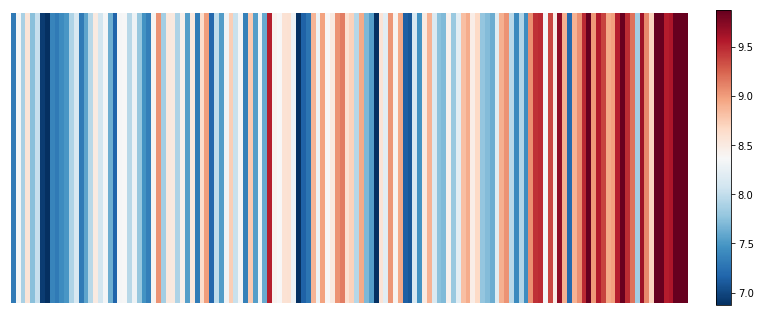

In [3]:
def plot_warming_stripes(stacked_temps, method):
    ###############
    plt.figure(figsize=(10,20))
    tavg = np.average(temps)
    if method == 0:
        #scale on average value +- 1.5 degree celcius
        vmin = tavg - 1.5
        vmax = tavg + 1.5
        img = plt.imshow(stacked_temps, cmap='RdBu_r', aspect=30, vmin=vmin, vmax=vmax)
    else: 
        #automatically scale on max and min temperature value
        img = plt.imshow(stacked_temps, cmap='RdBu_r', aspect=30)
    
    plt.gca().set_axis_off()
    plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)
    plt.margins(0,0)
    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())
    plt.colorbar(img,fraction=0.0205, pad=0.04)
    plt.savefig("stripes.png", bbox_inches = 'tight', pad_inches = 0, dpi=400)

plot_warming_stripes(stacked_temps, 0)

# Assignment Tasks: 

# Task 1: Data Aquisition

### Download and inspect the actual [data set](https://opendata.dwd.de/climate_environment/CDC/regional_averages_DE/monthly/air_temperature_mean/) to the folder ```./data/``` and inspect the files.   
There are 12 input files, one for each month. Every file contains a table with one line per year. In every line, the first column denotes the year, the second colum the month of the year, and the rest of the columns give us average temperature values of different regions in germany of the particular month. 

Alternatively get data from: https://www.ncdc.noaa.gov/cdo-web/datasets   
or: https://www.kaggle.com/berkeleyearth/climate-change-earth-surface-temperature-data   
or: http://berkeleyearth.org/archive/analysis-code/   



# Task 2: Data Preprocessing Routine
       
There are multiple options to approach our problem. We could include these pre-processings steps into our mapper function completely. However our map-reduce approach then is only able to process only this particular type of formatted input data. We, however, want to keep our implementation as flexible as possible so that our map and reduce functions can be applied to any kind of data that needs to be averaged. That's why we add a pre-processing step that cleans up our data in advance, before it is processed by the mapper.

In [4]:
with open('./Data/regional_averages_tm_01.txt', 'r') as f:
    print((f.read().splitlines(True))[:3])
    f.close()

['Zeitreihen fuer Gebietsmittel fuer Bundeslaender und Kombinationen von Bundeslaender, erstellt am: 20201104\n', 'Jahr;Monat;Brandenburg/Berlin;Brandenburg;Baden-Wuerttemberg;Bayern;Hessen;Mecklenburg-Vorpommern;Niedersachsen;Niedersachsen/Hamburg/Bremen;Nordrhein-Westfalen;Rheinland-Pfalz;Schleswig-Holstein;Saarland;Sachsen;Sachsen-Anhalt;Thueringen/Sachsen-Anhalt;Thueringen;Deutschland;\n', '1881;01;    -5.54;    -5.56;    -4.89;    -6.51;    -5.68;    -5.07;    -4.55;    -4.55;    -4.21;    -4.49;    -4.06;    -4.15;    -6.22;    -5.89;    -6.28;    -6.76;    -5.36;\n']


For instance, we want to replace the ```";"``` with a ```"\t"``` separator for better readabillity. 
Also, as you might notice, the last column already contains the average temperature for the respective month in a year.    
Due to the fact, that we want to process the average values ourself, we remove this column during our preprocessing step.
The first two rows containing the table header are also stripped from the files and the 2nd column with the information on the months gets taken out.

### Write a pre-processing routine

In [9]:
def preprocess_features(textinput):
    txt = textinput.replace(' ', '').replace(';', '\t').splitlines(True)
    wtxt = []
    #remove first two rows, they contain table heads and no data
    for j in range(2,len(txt)): 
        #split and remove last column, as it already includes the average value
        temp = (txt[j].split("\t"))[:-2]
        try:
            #remove second column, as it only includes the month and we don't need it
            temp.pop(1)
            wtxt.append('\t'.join(temp))
        except:
            # e.g. empty line
            continue
    textout ='\n'.join(wtxt)
    return textout            

### Let's test the routine:

In [10]:
with open('./Data/regional_averages_tm_01.txt', 'r') as f:
    data = f.read()
    f.close()
prep = preprocess_features(data)
print(prep)

1881	-5.54	-5.56	-4.89	-6.51	-5.68	-5.07	-4.55	-4.55	-4.21	-4.49	-4.06	-4.15	-6.22	-5.89	-6.28	-6.76
1882	1.43	1.42	-0.65	-1.33	-0.30	1.59	1.73	1.73	1.26	-0.17	2.11	-0.04	0.63	1.18	0.60	-0.12
1883	-0.41	-0.42	-0.09	-1.49	0.04	-0.69	0.33	0.32	1.27	0.49	-0.12	0.55	-1.20	-0.39	-0.69	-1.07
1884	3.35	3.34	2.34	1.22	2.97	3.16	3.99	3.99	4.17	3.24	3.56	3.24	2.39	3.32	2.93	2.43
1885	-2.15	-2.16	-3.88	-4.91	-2.66	-1.71	-1.44	-1.44	-1.14	-2.01	-1.09	-2.00	-2.87	-2.86	-3.36	-3.98
1886	-0.96	-0.96	-1.44	-2.95	-1.01	-0.97	-0.41	-0.41	0.19	-0.34	-0.50	-0.22	-1.59	-1.11	-1.51	-2.01
1887	-3.13	-3.14	-4.42	-5.90	-4.34	-2.74	-2.27	-2.26	-1.79	-3.26	-2.12	-2.90	-3.81	-3.51	-4.27	-5.23
1888	-1.18	-1.19	-2.96	-4.01	-2.09	-1.13	-0.51	-0.51	-0.67	-2.01	-0.45	-1.80	-2.08	-0.93	-1.52	-2.27
1889	-2.96	-2.97	-2.47	-3.55	-2.14	-2.94	-1.60	-1.60	-0.78	-1.76	-1.40	-1.53	-3.08	-2.58	-2.79	-3.05
1890	2.14	2.13	1.78	0.75	2.03	1.90	3.05	3.04	3.36	2.38	2.58	2.74	1.66	2.42	2.03	1.52
1891	-3.97	-3.99	-5.34	-6.53	-4.51	-4.0

# Task 3: Write the Mapper

### Now we have to write the code for the mapper function.   
What we want to do in this step, is to calculate an intermediate average value for each line of the input file by averaging all of the values from individual states in germany in one line.  
As stated earlier, every single line represents the data of one year and one month in germany in the past. 
The output contains a key (the year) and a value (the average temperature of the month belonging to the input file)
   
If you take the whole code-block below and save it as a file named 'mapper.py', you can use it later for the tests with Hadoop Streaming.

In [11]:
#!/usr/bin/env python

import sys 
import numpy as np

def mapper(textinput):
    #preprocess files to get data into shape
    textinput = preprocess_features(textinput)
    # input comes from STDIN (standard input)
    returnstring = ""
    for line in textinput.splitlines():
        # split the line into words
        #words = line.split()
        try:
            # remove leading and trailing whitespace
            line = line.strip()
            data = np.fromstring(line, dtype=float, sep='\t')
            returnstring = returnstring + ('%s\t%s\n' % (str(data[0]), str(np.average(data[2:]))))
        except:
            # e.g. empty line
            continue
        # increase counters
    print (returnstring)
    return returnstring

mapper(sys.stdin.read())

''

Giving it a try, we see that the calculation of an average temperature for each line that the mapper gets, works just fine.

In [12]:
output = mapper("Header\nHeader\n1881	01	-5.54	-5.56	-4.89	-6.51	-5.68	-5.07	-4.55	-4.55	-4.21	-4.49	-4.06	-4.15	-6.22	-5.89	-6.28	-6.76	-5.36\n\n1882	01	1.43	1.42	-0.65	-1.33	-0.30	1.59	1.73	1.73	1.26	-0.17	2.11	-0.04	0.63	1.18	0.60	-0.12	0.41\n\n1883	01	-0.41	-0.42	-0.09	-1.49	0.04	-0.69	0.33	0.32	1.27	0.49	-0.12	0.55	-1.20	-0.39	-0.69	-1.07	-0.32")


1881.0	-5.150714285714286
1882.0	0.6971428571428572
1883.0	-0.14928571428571427



# Task 4: Write the Reducer

The reducers gets the key-value pairs coming out of the mappers. In our case, there are now 12 key-value pairs per year, one for each month of the year.  The reducer only has to add up every one of these and divide them by the amount ouf values (12 in our case, one for each month) to compute the annual average temperature for one year. 
   
### Write the reducer   
   
Take the whole code-block below and save it as a file named 'reducer.py', to use it later for the tests with Hadoop Streaming.

In [13]:
#!/usr/bin/env python
#Reducer.py
import sys

year_temp = {}

def reducer(textinput):
    #Partitoner
    returnstring = "\n"
    year_temp = {}
    
    for line in textinput.splitlines():
        try:
            line = line.strip()
            year, temp = line.split('\t')
            if year in year_temp:
                year_temp[year].append(float(temp))
            else:
                year_temp[year] = []
                year_temp[year].append(float(temp))
        except:
            #empty line
            continue

    #Reducer
    for year in year_temp.keys():
        ave_temp = sum(year_temp[year])*1.0 / len(year_temp[year])
        print('%s\t%s'% (year, ave_temp))
        returnstring += ('%s\t%s\n' % (year, ave_temp))
       
    print(returnstring)
    return returnstring
        
reducer(sys.stdin.read())

'\n'

# Task 5: Test the Full "Pipeline" Without Hadoop Streaming

### Tiny Test Case
In the next step, we take 4 example lines to see whether the computations works

In [20]:
output = mapper("Header\nHeader\n1881	02	-1.00	-1.01	1.33	-0.73	0.75	-2.01	-0.05	-0.07	1.64	1.45	-1.81	2.25	-0.92	-0.42	-0.34	-0.25	-0.10\n1881	01	-5.54	-5.56	-4.89	-6.51	-5.68	-5.07	-4.55	-4.55	-4.21	-4.49	-4.06	-4.15	-6.22	-5.89	-6.28	-6.76	-5.36\n1882	01	1.43	1.42	-0.65	-1.33	-0.30	1.59	1.73	1.73	1.26	-0.17	2.11	-0.04	0.63	1.18	0.60	-0.12	0.41\n1883	01	-0.41	-0.42	-0.09	-1.49	0.04	-0.69	0.33	0.32	1.27	0.49	-0.12	0.55	-1.20	-0.39	-0.69	-1.07	-0.32")
output=sorted(output.split('\n'))
output='\n'.join(output)
print("Reducer Output: \n============================\n")
output = reducer(output)

1881.0	0.004285714285714297
1881.0	-5.150714285714286
1882.0	0.6971428571428572
1883.0	-0.14928571428571427

Reducer Output: 

1881.0	-2.5732142857142857
1882.0	0.6971428571428572
1883.0	-0.14928571428571427

1881.0	-2.5732142857142857
1882.0	0.6971428571428572
1883.0	-0.14928571428571427



### Full Data Set

Now we test the mapper and reducer on all of our data points. To do so, we create a large list of strings from all of our input files.   
This list is passed to a single mapper. Later, when we are using the Map-Reduce Framework, every Mapper only gets a smaller portion of the input data and the processing is executed in parallel. But for now the tests wont run in the cluster environment.

In [21]:
import glob   
path = 'Data/regional_averages_tm_'   
inputstring = ""
files=glob.glob(path+'*.txt')   
for file in files:     
    f=open(file, 'r')  
    inputstring += f.read() + "\n"  
    f.close() 
print(inputstring)

Zeitreihen fuer Gebietsmittel fuer Bundeslaender und Kombinationen von Bundeslaender, erstellt am: 20201104
Jahr;Monat;Brandenburg/Berlin;Brandenburg;Baden-Wuerttemberg;Bayern;Hessen;Mecklenburg-Vorpommern;Niedersachsen;Niedersachsen/Hamburg/Bremen;Nordrhein-Westfalen;Rheinland-Pfalz;Schleswig-Holstein;Saarland;Sachsen;Sachsen-Anhalt;Thueringen/Sachsen-Anhalt;Thueringen;Deutschland;
1881;01;    -5.54;    -5.56;    -4.89;    -6.51;    -5.68;    -5.07;    -4.55;    -4.55;    -4.21;    -4.49;    -4.06;    -4.15;    -6.22;    -5.89;    -6.28;    -6.76;    -5.36;
1882;01;     1.43;     1.42;    -0.65;    -1.33;    -0.30;     1.59;     1.73;     1.73;     1.26;    -0.17;     2.11;    -0.04;     0.63;     1.18;     0.60;    -0.12;     0.41;
1883;01;    -0.41;    -0.42;    -0.09;    -1.49;     0.04;    -0.69;     0.33;     0.32;     1.27;     0.49;    -0.12;     0.55;    -1.20;    -0.39;    -0.69;    -1.07;    -0.32;
1884;01;     3.35;     3.34;     2.34;     1.22;     2.97;     3.16;     3.99

### Test your code using the full data set

In [22]:
print("Mapper Output: \n============================\n")
output = mapper(inputstring.replace("\n\n", "\n"))
output=sorted(output.replace("\n\n", "\n").split('\n'))
output='\n'.join(output)
print("Reducer Output: \n============================\n")
output = reducer(output)
output = sorted(output.split('\n'))
output = '\n'.join(output)


Mapper Output: 

1881.0	-5.258
1882.0	0.6426666666666667
1883.0	-0.21066666666666667
1884.0	3.086
1885.0	-2.5006666666666666
1886.0	-1.0159999999999998
1887.0	-3.4639999999999995
1888.0	-1.6086666666666665
1889.0	-2.282666666666666
1890.0	2.224666666666667
1891.0	-4.228000000000001
1892.0	-1.6493333333333333
1893.0	-6.96
1894.0	-1.5386666666666666
1895.0	-3.745333333333333
1896.0	-0.46
1897.0	-2.824666666666666
1898.0	2.5326666666666666
1899.0	2.3273333333333337
1900.0	0.9146666666666667
1901.0	-3.6753333333333336
1902.0	2.976
1903.0	0.5926666666666666
1904.0	-1.1073333333333333
1905.0	-1.512
1906.0	1.2480000000000002
1907.0	-0.14066666666666666
1908.0	-1.9019999999999997
1909.0	-1.4053333333333335
1910.0	1.6226666666666667
1911.0	-0.638
1912.0	-1.4633333333333334
1913.0	-0.010666666666666625
1914.0	-2.7179999999999995
1915.0	0.384
1916.0	3.905333333333333
1917.0	-2.4733333333333336
1918.0	0.9006666666666665
1919.0	0.7306666666666667
1920.0	2.332
1921.0	4.343333333333333
1922.0	-2.638


<ipython-input-8-edda6d368de8>:17: DeprecationWarning: string or file could not be read to its end due to unmatched data; this will raise a ValueError in the future.
  data = np.fromstring(line, dtype=float, sep='\t')


### Inspect the mapper input and output and reducer input and output. Are the results reasonable? If not, re-write the mapper and reducer

# Task 6: Plot and Validate the Results 

### Now, we use the visualisation function to plot our results

Maximum Temperature: 11.709333333333335
Minimum Temperature: 6.692111111111111
Average Temperature: 8.478126984126984


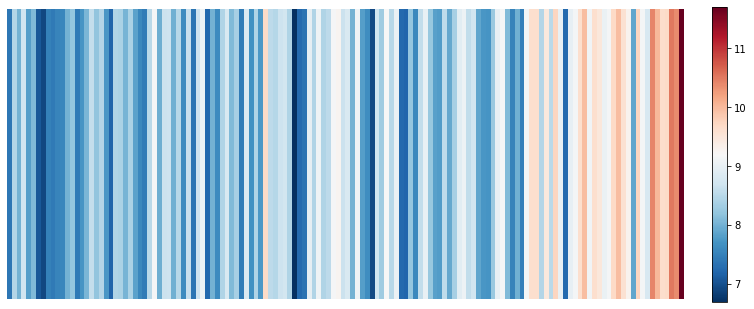

In [23]:
data = np.fromstring(output, dtype=float, sep='\t').reshape((-1, 2))
temps = data[:,1]
stacked_temps = np.stack((temps, temps))

tmin = temps.min() 
tmax = temps.max() 
tavg = np.average(temps)

print("Maximum Temperature: " + str(tmax))
print("Minimum Temperature: " + str(tmin))
print("Average Temperature: " + str(tavg))

plot_warming_stripes(stacked_temps, 1)

The result might look a bit off. Inspect the data sources and especially the last year. 
Is there an entry for every single month of the last year available? If not, remove the entire year from the plot.    
### Why is it important to check, if there is there is data for the whole duration of each year?   
### What are the differences between:    
### ```plot_warming_stripes(stacked_temps, 0)``` and ```plot_warming_stripes(stacked_temps, 1)```

Maximum Temperature: 10.529166666666667
Minimum Temperature: 6.692111111111111
Average Temperature: 8.454880895283774


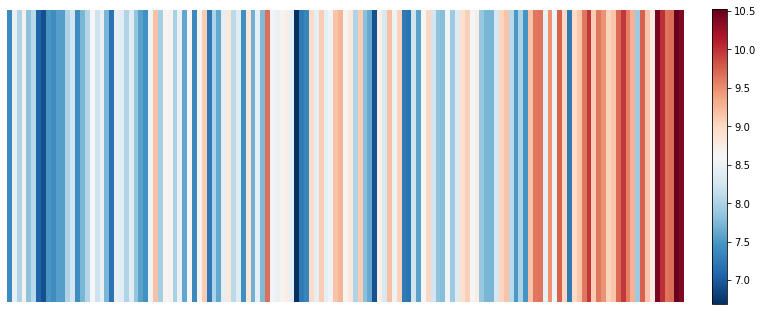

In [24]:
data = np.fromstring(output, dtype=float, sep='\t').reshape((-1, 2))
temps = data[:-1,1]
stacked_temps = np.stack((temps, temps))

tmin = temps.min() 
tmax = temps.max() 
tavg = np.average(temps)

print("Maximum Temperature: " + str(tmax))
print("Minimum Temperature: " + str(tmin))
print("Average Temperature: " + str(tavg))

plot_warming_stripes(stacked_temps, 1)

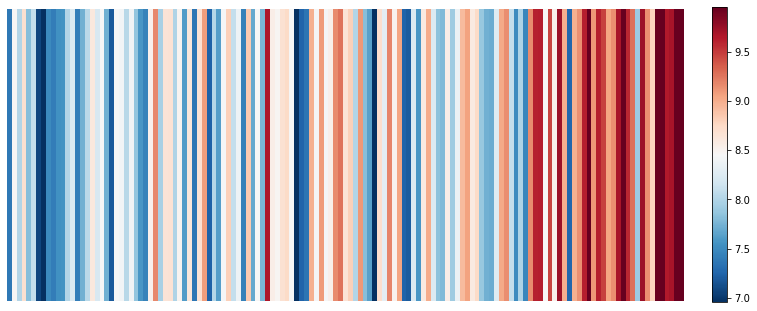

In [25]:
plot_warming_stripes(stacked_temps, 0)

# Task 8: Test Functionality with Hadoop Streaming on ARA-Cluster: 

As a last step, we copy our input data into the Hadoop Disrtributed File System (HDFS) into a folder called "Data" and we copy our mapper.py and reducer.py files into our Hadoop cluster.  
We can test out the code by calling: 

`time hadoop jar /usr/lib/hadoop-mapreduce/hadoop-streaming.jar -files mapper.py,reducer.py -mapper mapper.py -reducer reducer.py -input Data -output Temp`   
   
The results can be found in the output folder "Temp" and by calling

`hdfs dfs -cat Temp/*` 

We can inspect the results and, again, plot them. 
By using Hadoop, we create one mapper for each input file. Every mapper can compute the intermediate average values separately and independently. Each mapper creates one key-value-pair for ever single line in its respective input file. 
The reducer then averages all the values of the key-value-pairs that share the same key. 

### Run the Code on the ARA-Cluster

# Bonus: Scalability

How could we enhance our example?
As stated earlier, our example can easily be expanded by just using more data points and more input files. Test out some of the other data sources.